In [2]:
import pickle

import joblib
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import xgboost as xgb
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [3]:
# Load the dataset
data = pd.read_csv(
    r"C:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\model-1\training_data.csv"
)

In [4]:
# Update class-to-id mapping for 7 classes
label_mapping = {
    "No Hate/Toxic": 0,
    "Hate 1": 1,
    "Hate 2": 2,
    "Hate 3": 3,
    "Toxic 1": 4,
    "Toxic 2": 5,
    "Toxic 3": 6,
}
# Encode gold labels
data["Classification"] = data["Classification"].astype(str)
data["Classification"] = data["Classification"].map(label_mapping)
data["text"] = data["text"].astype(str)

In [5]:
# Divide features and labels
X = data["text"]
y = data["Classification"]

In [6]:
# Split dataset into training, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

### Text Processing Function ###

In [7]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download("punkt_tab")
nltk.download("wordnet")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    # Tokenization
    words = word_tokenize(text.lower())

    # Remove punctuation and non-alphabetic tokens
    words = [word for word in words if word.isalpha()]

    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# Preprocess the training and test data
X_train_proc = [preprocess(text) for text in X_train]
X_test_proc = [preprocess(text) for text in X_test]
X_valid_proc = [preprocess(text) for text in X_test]

In [9]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train_proc)
X_valid_vectorized = vectorizer.fit_transform(X_valid_proc)
X_test_vectorized = vectorizer.fit_transform(X_test_proc)

In [10]:
# save  vectorizer
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

In [11]:
print(y_train.value_counts())

Classification
1    15849
4    10568
0    10555
5     3894
2      677
6      302
3      155
Name: count, dtype: int64


In [12]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

target_count = 5000

# Oversample the minority classes
smote = SMOTE(
    sampling_strategy={
        3: target_count,  # Increase "Hate 3" to target_count
        6: target_count,  # Increase "Toxic 3" to target_count
        2: target_count,  # Increase "Hate 2" to target_count
        5: target_count,  # Increase "Toxic 2""
    },
    random_state=42,
)

X_train_smote, y_train_smote = smote.fit_resample(X_train_vectorized, y_train)

# Undersampling to reduce the majority class instances
undersampler = RandomUnderSampler(
    sampling_strategy={
        1: target_count,  # Reduce "Hate 1"
        4: target_count,  # Reduce "Toxic 1"
        0: target_count,  # Reduce "No Hate/Toxic"
    },
    random_state=42,
)

X_train_balanced, y_train_balanced = undersampler.fit_resample(
    X_train_smote, y_train_smote
)

print(y_train_balanced.value_counts())

Classification
0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
Name: count, dtype: int64


## Classification Models ##

### RidgeClassifierCV ###

In [13]:
# Train the classifier
clf = RidgeClassifierCV(class_weight="balanced")
clf.fit(X_train_balanced, y_train_balanced)

# Predict on the validation data
y_val_pred_ridge = clf.predict(X_valid_vectorized)

# Evaluate the predictions on validation data
print("Validation Accuracy: %s" % accuracy_score(y_valid, y_val_pred_ridge))
print(
    "Validation Classification Report:\n",
    classification_report(
        y_valid, y_val_pred_ridge, target_names=list(label_mapping.keys())
    ),
)
print(
    "Validation F1-Score: %s" % f1_score(y_valid, y_val_pred_ridge, average="weighted")
)

# Predict on the test data
y_pred_ridge = clf.predict(X_test_vectorized)

# Evaluate the predictions on test data
print("Test Accuracy: %s" % accuracy_score(y_test, y_pred_ridge))
print(
    "Test Classification Report:\n",
    classification_report(
        y_test, y_pred_ridge, target_names=list(label_mapping.keys())
    ),
)
print("Test F1-Score: %s" % f1_score(y_test, y_pred_ridge, average="weighted"))

Validation Accuracy: 0.23133333333333334
Validation Classification Report:
                precision    recall  f1-score   support

No Hate/Toxic       0.25      0.41      0.31      2262
       Hate 1       0.38      0.19      0.25      3396
       Hate 2       0.01      0.02      0.01       145
       Hate 3       0.00      0.03      0.01        33
      Toxic 1       0.25      0.17      0.20      2264
      Toxic 2       0.10      0.14      0.12       835
      Toxic 3       0.01      0.06      0.02        65

     accuracy                           0.23      9000
    macro avg       0.14      0.15      0.13      9000
 weighted avg       0.28      0.23      0.24      9000

Validation F1-Score: 0.23588016089097735
Test Accuracy: 0.22844444444444445
Test Classification Report:
                precision    recall  f1-score   support

No Hate/Toxic       0.25      0.41      0.31      2262
       Hate 1       0.39      0.19      0.25      3396
       Hate 2       0.01      0.03      0.02 

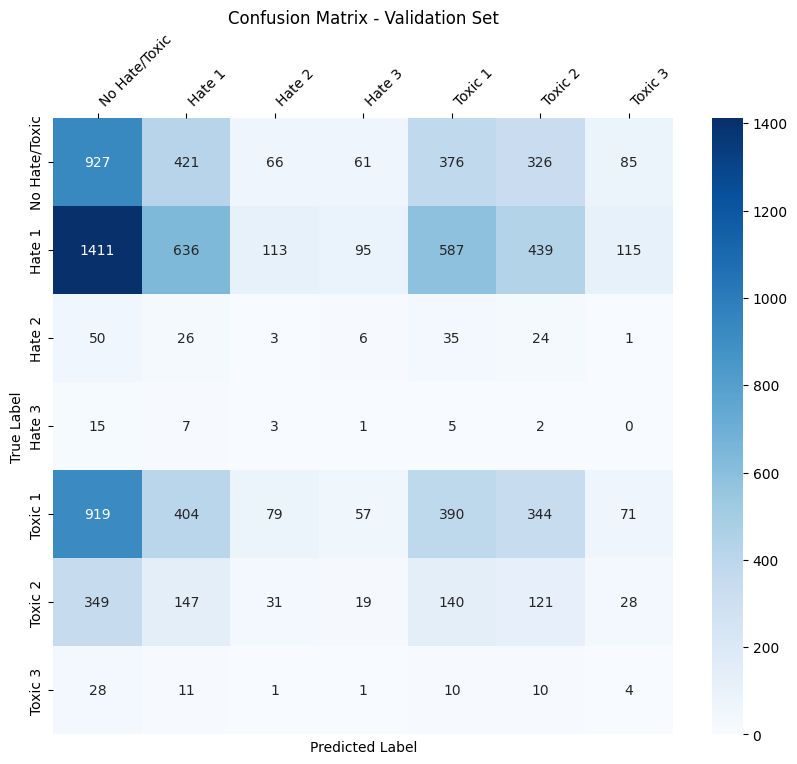

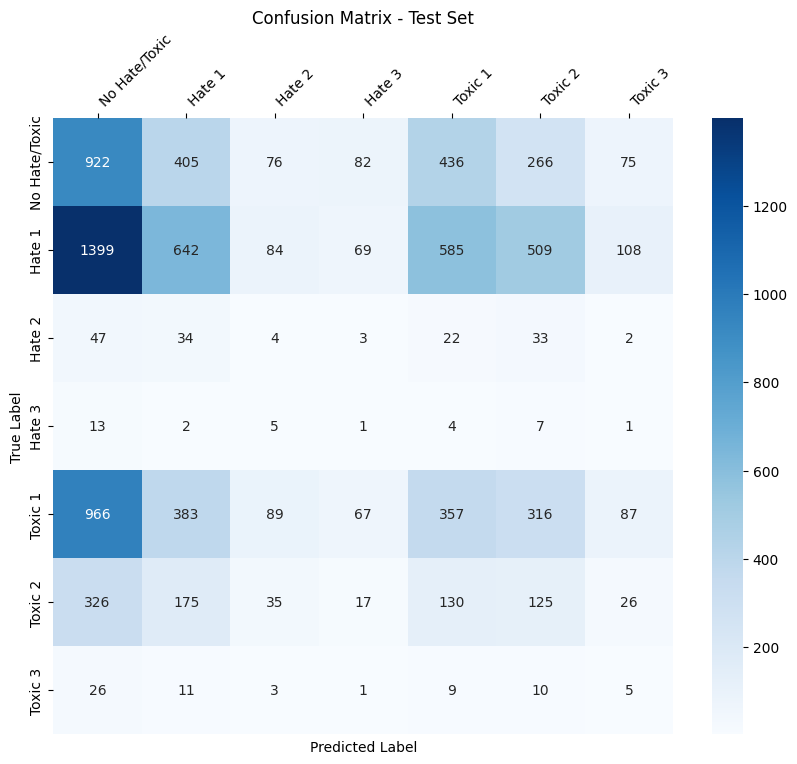

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_valid, y_val_pred_ridge)

# Plot the confusion matrix for validation set
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    conf_matrix_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Move the x-axis to the top and rotate x-axis labels
ax.xaxis.set_ticks_position("top")
plt.xticks(rotation=45, ha="left")

plt.show()

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_ridge)

# Plot the confusion matrix for test set
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    conf_matrix_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Move the x-axis to the top and rotate x-axis labels
ax.xaxis.set_ticks_position("top")
plt.xticks(rotation=45, ha="left")

plt.show()

In [15]:
# Save the trained model to a file
joblib.dump(clf, "ridge_classifier_model.pkl")
print("Model saved as ridge_classifier_model.pkl")

Model saved as ridge_classifier_model.pkl


### XGBoost ###

In [21]:
# Create a pipeline that includes TF-IDF vectorizer and XGBoost classifier
pipeline = Pipeline(
    [
        # ("tfidf", TfidfVectorizer()),  # Add TF-IDF vectorization to the pipeline
        (
            "xgb",
            xgb.XGBClassifier(
                objective="multi:softmax",  # Multiclass classification
                num_class=7,  # Number of classes (7)
                eval_metric="mlogloss",  # Multiclass log-loss as evaluation metric
                use_label_encoder=False,  # Disable label encoding warning
            ),
        ),
    ]
)

# Define parameter grid for GridSearchCV (for both TF-IDF and XGBoost)
param_grid = {
    # "tfidf__max_features": [10000],  # Adjust vocabulary size
    "xgb__max_depth": [3, 5],  # Control the complexity of the trees
    "xgb__learning_rate": [0.1, 0.2],  # Speed of model learning
    "xgb__n_estimators": [100, 150],  # Number of trees in the ensemble
    "xgb__subsample": [0.7, 1.0],  # Subsampling for robustness
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,  # 3-fold cross-validation for speed
    verbose=1,  # Show progress
    n_jobs=-1,  # Use all available cores
)

# Fit the grid search to the raw text data
grid_search.fit(X_train_balanced, y_train_balanced)  # Note: Replace with raw text data

# Get the best parameters found by GridSearchCV
print("Best parameters found:", grid_search.best_params_)

# Predict on the test data using the best model
y_pred_best = grid_search.best_estimator_.predict(X_test_vectorized)

# Print accuracy and classification report
print("Accuracy: %s" % accuracy_score(y_test, y_pred_best))
print(
    classification_report(y_test, y_pred_best, target_names=list(label_mapping.keys()))
)
print("Test F1-Score: %s" % f1_score(y_test, y_pred_best))

# Optional: Predict on the validation set to evaluate performance
y_val_pred_best = grid_search.best_estimator_.predict(X_valid_vectorized)
print("Validation Accuracy: %s" % accuracy_score(y_valid, y_val_pred_best))
print(
    classification_report(
        y_valid, y_val_pred_best, target_names=list(label_mapping.keys())
    )
)
print("Validation F1-Score: %s" % f1_score(y_test, y_val_pred_ridge))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\penv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 150, 'xgb__subsample': 0.7}
Accuracy: 0.2447777777777778
               precision    recall  f1-score   support

No Hate/Toxic       0.25      0.83      0.39      2262
       Hate 1       0.45      0.02      0.03      3396
       Hate 2       0.00      0.00      0.00       145
       Hate 3       0.00      0.00      0.00        33
      Toxic 1       0.22      0.11      0.15      2265
      Toxic 2       0.06      0.02      0.03       834
      Toxic 3       0.11      0.05      0.06        65

     accuracy                           0.24      9000
    macro avg       0.16      0.15      0.09      9000
 weighted avg       0.30      0.24      0.15      9000



ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [18]:
# Save the best model (the entire pipeline with TF-IDF and XGBoost) to a file
joblib.dump(grid_search.best_estimator_, "best_tfidf_xgb_model.pkl")
print("Model saved as best_tfidf_xgb_model.pkl")

Model saved as best_tfidf_xgb_model.pkl


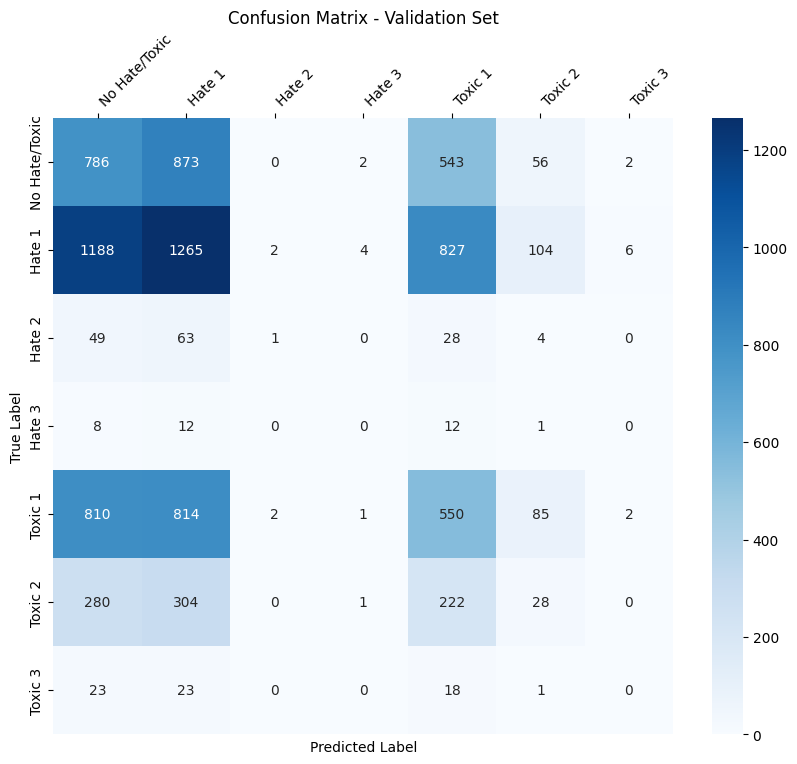

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_valid, y_val_pred_best)

# Plot the confusion matrix for the validation set
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    conf_matrix_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Move the x-axis to the top and rotate x-axis labels
ax.xaxis.set_ticks_position("top")
plt.xticks(rotation=45, ha="left")

plt.show()

### Naive Bayes Classifier ###

Multinomial Naive Bayes classifier - A generative classifier which models how a class could generate some input data. Given an observation, they return the class most likely to have generated the observation

In [18]:
# Create a pipeline with CountVectorizer, TfidfTransformer, and MultinomialNB
custom_stop_words = ["and", "the", "is", "to", "in"]
nb = Pipeline(
    [
        ("clf", MultinomialNB()),  # Multinomial Naive Bayes classifier
    ]
)

# Fit the model to the training data
nb.fit(X_train_balanced, y_train_balanced)

# Predict on the validation set
y_pred_nb = nb.predict(X_test_vectorized)

# Evaluate the predictions
print("Accuracy: %s" % accuracy_score(y_pred_nb, y_test))
print(classification_report(y_test, y_pred_nb, target_names=list(label_mapping.keys())))

Accuracy: 0.207
               precision    recall  f1-score   support

No Hate/Toxic       0.24      0.31      0.27      2262
       Hate 1       0.37      0.19      0.26      3396
       Hate 2       0.01      0.02      0.01       145
       Hate 3       0.01      0.09      0.01        33
      Toxic 1       0.24      0.15      0.18      2265
      Toxic 2       0.09      0.17      0.12       834
      Toxic 3       0.01      0.09      0.03        65

     accuracy                           0.21      9000
    macro avg       0.14      0.15      0.13      9000
 weighted avg       0.27      0.21      0.22      9000



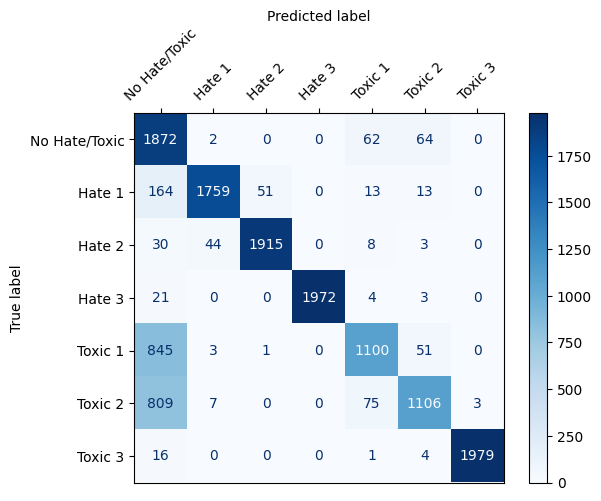

In [27]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_nb)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=list(label_mapping.keys())
)
disp.plot(cmap=plt.cm.Blues)  # You can change the color map if desired
ax = plt.gca()
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
plt.xticks(rotation=45)
plt.show()

### Linear SVM ###

In [19]:
# Create a pipeline with CountVectorizer, TfidfTransformer, and SGDClassifier
sgd = Pipeline(
    [
        # ("vect", CountVectorizer()),  # Convert text to a matrix of token counts
        # ("tfidf", TfidfTransformer()),  # Apply TF-IDF transformation
        (
            "clf",
            SGDClassifier(
                loss="hinge",
                penalty="l2",
                alpha=1e-3,
                random_state=42,
                max_iter=5,
                tol=None,
            ),
        ),  # Linear SVM
    ]
)

# Fit the model to the training data
sgd.fit(
    X_train_balanced, y_train_balanced
)  # 'text' refers to the text column in your dataset

# Predict on the validation set
y_pred_svm = sgd.predict(X_test_vectorized)

# Evaluate the predictions
print("Accuracy: %s" % accuracy_score(y_pred_svm, y_test))
print(
    classification_report(y_test, y_pred_svm, target_names=list(label_mapping.keys()))
)

Accuracy: 0.20822222222222223
               precision    recall  f1-score   support

No Hate/Toxic       0.25      0.64      0.36      2262
       Hate 1       0.37      0.07      0.11      3396
       Hate 2       0.02      0.01      0.01       145
       Hate 3       0.01      0.09      0.01        33
      Toxic 1       0.24      0.07      0.10      2265
      Toxic 2       0.10      0.06      0.07       834
      Toxic 3       0.01      0.12      0.02        65

     accuracy                           0.21      9000
    macro avg       0.14      0.15      0.10      9000
 weighted avg       0.27      0.21      0.17      9000



### Logistic Regression ###
Discriminative classifiers like logistic regression learn what features from the input are most useful to discriminate between the different possible classes.

In [40]:
# Define the pipeline with CountVectorizer, TfidfTransformer, and LogisticRegression
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),  # Convert text to a matrix of token counts
        ("tfidf", TfidfTransformer()),  # Apply TF-IDF transformation
        (
            "clf",
            LogisticRegression(max_iter=1000, solver="liblinear"),
        ),  # Logistic Regression classifier
    ]
)

# Define the parameter grid for GridSearchCV
param_grid = {
    "vect__ngram_range": [(1, 1), (1, 2)],  # Unigrams or bigrams
    "vect__max_df": [0.75, 1.0],  # Ignore terms with higher document frequency
    "vect__min_df": [1, 5],  # Ignore terms with lower document frequency
    "tfidf__use_idf": [True, False],  # Enable or disable IDF
    "clf__C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
    "clf__penalty": ["l1", "l2"],  # Regularization type
    # 'clf__solver': ['liblinear', 'saga']                  # Solver options compatible with penalties
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=2,  # 5-fold cross-validation for better reliability
    scoring="f1_weighted",  # Suitable for multi-class classification
    n_jobs=-1,  # Utilize all available cores
    verbose=1,  # For tracking progress
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_logreg2 = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_logreg2)
f1 = f1_score(y_test, y_pred_logreg2, average="weighted")

# Store the F1 score in a dictionary
model_f1_scores = {}
model_f1_scores["Logistic Regression"] = f1

# Print evaluation results
print(f"Best Parameters: {grid_search.best_params_}\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted F1 Score: {f1:.4f}\n")
print("Classification Report:")
print(
    classification_report(
        y_test, y_pred_logreg2, target_names=list(label_mapping.keys())
    )
)

Fitting 2 folds for each of 160 candidates, totalling 320 fits
Best Parameters: {'clf__C': 100, 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__max_df': 0.75, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}

Accuracy: 0.8668
Weighted F1 Score: 0.8693

Classification Report:
               precision    recall  f1-score   support

No Hate/Toxic       0.59      0.88      0.71      2000
       Hate 1       0.97      0.91      0.94      2000
       Hate 2       0.99      0.97      0.98      2000
       Hate 3       1.00      0.99      0.99      2000
      Toxic 1       0.83      0.63      0.72      2000
      Toxic 2       0.81      0.70      0.75      2000
      Toxic 3       1.00      0.99      0.99      2000

     accuracy                           0.87     14000
    macro avg       0.89      0.87      0.87     14000
 weighted avg       0.89      0.87      0.87     14000



In [42]:
# save results dictionary into a .pkl file
report = classification_report(
    y_test, y_pred_logreg2, target_names=list(label_mapping.keys())
)

results = {
    "best_model": best_model,
    "best_params": grid_search.best_params_,
    "accuracy": accuracy,
    "f1_score": f1,
    "classification_report": report,  # Save the report as a string
}

with open("logreg_model_and_results.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
# for retrieval

# Load the saved model and results from the pickle file
with open("logreg_model_and_results.pkl", "rb") as f:
    loaded_results = pickle.load(f)

# Access the saved data
loaded_model = loaded_results["best_model"]
best_params = loaded_results["best_params"]
accuracy = loaded_results["accuracy"]
f1_score = loaded_results["f1_score"]
classification_report = loaded_results["classification_report"]

print(f"Best Parameters: {best_params}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print("Classification Report:\n", classification_report)